In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from MMDBalancing import MMDBalancing as MMDB
from OptimalTransportBalancing import OptimalTransportBalancing as OTB
from NeuralAdversarialBalancing import NeuralAdversarialBalancing as NAB
%matplotlib inline


# utils
from utils_balancing import *

## Synthetic model

* $T = 9$ (`T` = 10 for code)
* $n$ varies
* $\xi_0^{\pi} = \mathcal{N}(0,\sigma^2)$ with $\sigma = 2$.
* $\mathring{\xi}_0^{\mathring{\pi}} = \mathcal{N}(0,(\sigma-h)^2)$ with $h = 0$ (no covariate shifts) or $h = 1$ (with covariate shifts).
* $\pi_t = 0.5* 0.5*sin(5x^2 + 7t) \times \log(t+4)  +  \mathcal{N}(0, \sigma_1^2)$ with $\sigma_1 = 0.2$.
* $\mathring{\pi}_t = 1 - 1/(1+|\exp(-1-x) - 5\exp(4-t)|) +  \mathcal{N}(0, \sigma_2^2)$ with $\sigma_2 = 0.3$.
* $M_t : \mathbf{1}_{\{x_t>-0.5\}}(x + 1/(1+10\exp(0.3x_t)))a_t + (\mathcal{N}(0, \sigma/(t+1)))^2 + \mathbf{1}_{\{x_t\leq -0.5 \}}x_t$

We consider 2 reward functions:
* $r_t^{\dagger}(x_{t+1}) = x_{t+1}^2$
* $r_t^{\ddagger}(x_{t+1}) = \mathbf{1}_{\{x_{t+1}\geq 0\}} \beta + \frac{1}{t+1}\sum_{s = 0}^t a_s$

In [2]:
sigma = 2
h = 0
T = 9
n = 10000
m = n
def pi_ring(x,t):
    return 1. - 1./(1 + torch.abs( torch.exp(-1-x) - 5*torch.exp(4.-t) ) )

def pi(x,t):
    return 0.5 + 0.5* torch.sin (5*x**2 + 7*t) * torch.log(t+1) 

# reward function
#r = lambda x:  5.*torch.exp(-x)*(x>0) +(x<0)*x.square()

r = lambda x: x.square()
    
def get_data(sigma = sigma,
            h = h,
            T =T,
            n = n,
            m = m):
    X = torch.zeros((T+1,n,1))
    X_ring_oracle = torch.zeros((T+1,m,1))
    X_natural = torch.zeros((T,n,2))
    
    X_natural_ring_oracle = torch.zeros((T,m,2))
    
    A = torch.zeros((T,n,1))
    A_ring_oracle = torch.zeros((T,m,1))
    
    #X[0] = torch.normal(mean = -4 , std = sigma, size =(n,1) )
    for i in range(n):
        if torch.rand(1).item()>0.3:
            X[0,i] = torch.normal(mean = -4, std = 2, size = (1,))
        else:
            X[0,i] = torch.normal(mean = 3, std = 0.2, size = (1,))
    
    
    
    for i in range(n):
        if torch.rand(1).item()>0.3:
            X_ring_oracle[0,i] = torch.normal(mean = -4, std = 2/(h+0.5), size = (1,))
        else:
            X_ring_oracle[0,i] = torch.normal(mean = 3, std = 0.2, size = (1,))
    
    
    
    
    
    for t in range(T):
        A[t] = pi(X[t],torch.tensor([t])) + torch.normal(0,0.2,(n,1))
        A_ring_oracle[t] = pi_ring(X_ring_oracle[t],torch.tensor([t]))+ torch.normal(0,0.3,(m,1))
        X_natural[t] = torch.cat((X[t],A[t]),1)
        X_natural_ring_oracle[t] = torch.cat((X_ring_oracle[t],A_ring_oracle[t]),1)
        X[t+1] =\
                   t/5+ 1.*(X[t]>- 0.5) * (X[t] + 1./(1.+ 10*torch.exp(3*A[t])) + torch.normal(0,sigma/np.sqrt(t+1),size = (n,1))) +1.*(X[t] <=- 0.5) * X[t]
        X_ring_oracle[t+1] =\
                    t/5+ 1.*(X_ring_oracle[t]>- 0.5) * (X_ring_oracle[t] + 1./(1.+ 10*torch.exp(3*A_ring_oracle[t])) + torch.normal(0,sigma/np.sqrt(t+1),size = (m,1))) +1.*(X_ring_oracle[t] <=- 0.5) * X_ring_oracle[t]
    return X,A,X_natural,X_ring_oracle,A_ring_oracle,X_natural_ring_oracle

X,A,X_natural,X_ring_oracle,A_ring_oracle,X_ring_natural_oracle = get_data()

    
    

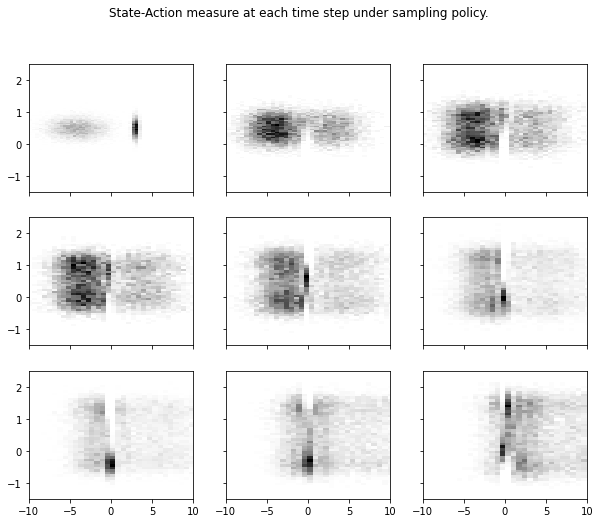

In [3]:
fig, axs = plt.subplots(3, 3,figsize = (10,8),sharex=True, sharey=True)
fig.suptitle('State-Action measure at each time step under sampling policy.')
for i in range(3):
    for j in range (3):
        t = 3*i+j
        axs[i,j].hist2d(X_natural[t,:,0].detach().numpy(),X_natural[t,:,1].detach().numpy(), bins = 40, density = True, cmap = "binary")
        axs[i,j].set_xlim((-10,10))
        axs[i,j].set_ylim((-1.5,2.5))


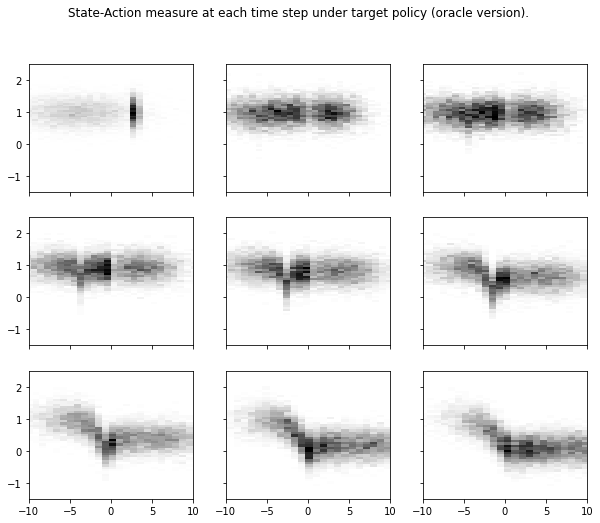

In [4]:
fig, axs = plt.subplots(3, 3,figsize = (10,8),sharex=True, sharey=True)
fig.suptitle('State-Action measure at each time step under target policy (oracle version).')
for i in range(3):
    for j in range (3):
        t = 3*i+j
        axs[i,j].hist2d(X_ring_natural_oracle[t,:,0].detach().numpy(),X_ring_natural_oracle[t,:,1].detach().numpy(), bins = 40, density = True, cmap = "binary")
        axs[i,j].set_xlim((-10,10))
        axs[i,j].set_ylim((-1.5,2.5)) 

## Data splitting


In [5]:
K = 3 # number of folds


def get_split_ind(n,K = K):
    I_n = torch.arange(n, dtype = float)
    
    rand_ind_n = torch.multinomial(I_n,len(I_n),replacement = False)
    num_folds_n = int(n/K)
    Ind = []
    for i in range(K):
        if (i+1)*num_folds_n <= n:
            Ind.append(list(rand_ind_n[i*num_folds_n:(i+1)*num_folds_n].detach().numpy()))
        else:
            Ind.append(list(rand_ind_n[i*num_folds_n:].detach().numpy()))
    
    Ind_split = []
    for i in range(K):
        list_n = []
        for j in range(n):
            if j >= i*num_folds_n and j < (i+1)*num_folds_n:
                pass
            else:
                list_n.append(rand_ind_n[j].item())
            
        Ind_split.append(list_n)
    return Ind_split,Ind
        
    

## GIPWE

In [6]:
# bootstrap multiplier for target policy sampler
B = 3

def get_X_natural(X,X_ring_0 = X_ring_oracle[0], B = 3):
    T = len(X) -1 
    A_ring = torch.zeros((T,m*B,1))
    X_ring = X.clone()
    _X_ring = X.clone()
    
    # covariate shifts
    _X_ring[0] = X_ring_0.clone()
    X_ring[0] = X_ring_0.clone()
    
    for b in range(B-1):
        X_ring = torch.cat((X_ring,_X_ring), dim = 1)
    
        
    for t in range(T):
        A_ring[t] = pi_ring(X_ring[t],torch.tensor([t]))+ torch.normal(0,0.3,(m*B,1))
    X_ring_natural = torch.cat((X_ring[0:-1], A_ring),dim = 2)
    return X_ring_natural,X_ring,A_ring

In [7]:
X_ring_natural,X_ring,A_ring = get_X_natural(X)

### Reference

In [8]:
def viz_marginal(w_all, direction = 0):
    fig, axs = plt.subplots(3, 3,figsize = (10,8),sharex=True, sharey=True)
    fig.suptitle('State-Action measure at each time step under target policy (re-weighted version).')
    for i in range(3):
        for j in range (3):
            t = 3*i+j
            axs[i,j].hist(X_natural[t,:,direction].detach().numpy(),weights = w_all[t],  bins = 30, density = True, alpha = 0.5, label = "re-weighted")
            axs[i,j].hist(X_ring_natural_oracle[t,:,direction].detach().numpy(),  bins = 30, density = True, alpha = 0.5, label = "reference")
            axs[i,j].legend()

def viz_ref(bins = 30):
    fig, axs = plt.sub
    fig.suptitle('State-Action measure at each time step under target policy (oracle version).')
    for i in range(3):
        for j in range (3):
            t = 3*i+j
            axs[i,j].hist2d(X_ring_natural_oracle[t,:,0].detach().numpy(),X_ring_natural_oracle[t,:,1].detach().numpy(), bins = bins, density = True, cmap = "binary")
            axs[i,j].set_xlim((-7,7))
            axs[i,j].set_ylim((-1.5,2.5)) 

def viz(w_all,bins = 30):
    fig, axs = plt.subplots(3, 3,figsize = (10,8),sharex=True, sharey=True)
    fig.suptitle('State-Action measure at each time step under target policy (re-weighted version).')
    for i in range(3):
        for j in range (3):
            t = 3*i+j
            axs[i,j].hist2d(X_natural[t,:,0].detach().numpy(),X_natural[t,:,1].detach().numpy(),weights = w_all[t],  bins = bins, density = True, cmap = "binary")
            axs[i,j].set_xlim((-7,7))
            axs[i,j].set_ylim((-1.5,2.5)) 

In [9]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

#SGIPW = Shallow_GIPW(X_natural[0], X_ring_natural_oracle[0], w = np.ones(n), w_ring = np.ones(m), bootstrap_multiplier = 1)
#SGIPW.train(RF,log=True)
#weights = SGIPW.weights


In [121]:
n = 1000
m = 1000
B = 3
T = 9
K = 2
h = 0

X,A,X_natural,X_ring_oracle,A_ring_oracle,X_ring_natural_oracle = get_data(n = n,m = m,  h = h)
X_ring_natural,X_ring,A_ring = get_X_natural(X, X_ring_oracle[0], B=B)

Ind_out_n, Ind_in_n = get_split_ind(n,K)
Ind_out_m, Ind_in_m = get_split_ind(B*m,B)


w = np.ones(n)
w_ring = np.ones(m*B)
w_all = np.ones((T,n))

#model =LogisticRegression(penalty = "none")
#model = RandomForestRegressor(n_estimators = 100, min_samples_split = 100)
model = xgb.XGBRegressor(n_estimators = 20, gamma = 2e0)
for t in range(T):
    #print("T = {}:".format(t))
    for k in range(K):
        
        #print("Fold {}:".format(k+1))
        
        SGIPW = Shallow_GIPW(X_natural[t,Ind_out_n[k],:], X_ring_natural[t], w_ring = w_ring, bootstrap_multiplier = 2)
        
        SGIPW.train(model,xi = np.array(X_natural[t,Ind_in_n[k],:]),log=False)
        w_all[t,Ind_in_n[k]] = SGIPW.weights*(SGIPW.weights>0)
        #print("\n")
    #w = w_all[t]
    w_ring = w_all[t]
    for b in range(B-1):
        w_ring = np.concatenate((w_ring,w_all[t]))

In [122]:

def get_reward(w_all, X = X):
    out = 0
    for t in range(T):
        out += (r(X[t+1])*w_all[t]).mean()
    try:
        out = out.item()
    except:
        pass
    return out

get_reward(w_all)
def get_ref(T = T, h = h):
    X,A,X_natural,X_ring_oracle,A_ring_oracle,X_ring_natural_oracle = get_data(m = 10000, h = h)
    out = 0
    for t in range(T):
        out +=  r(X_ring_oracle[t+1]).mean()
        
    return out
def get_base(T = T,h = h):
    X,A,X_natural,X_ring_oracle,A_ring_oracle,X_ring_natural_oracle = get_data(m = 10000,h = h)
    out = 0
    for t in range(T):
        out +=  r(X[t+1]).mean()
        
    return out

print("base (no correction):{}".format(get_base(h = h)))
print("ref:{}".format(get_ref(h = h)))

base (no correction):211.0178985595703
ref:289.1568908691406


In [123]:
get_reward(w_all)

351.67774657562967

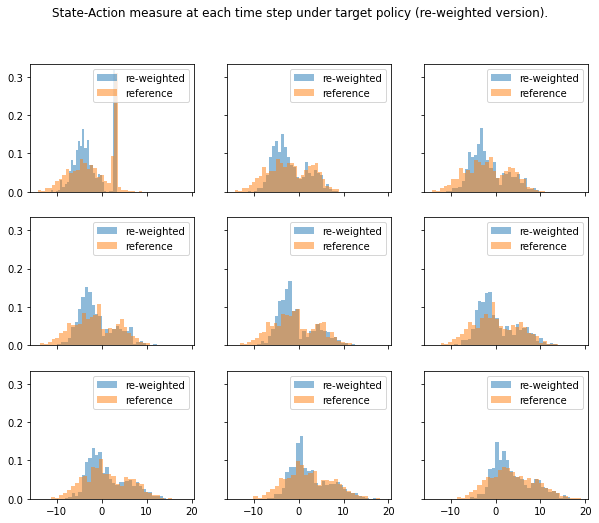

In [124]:
viz_marginal(w_all,0)

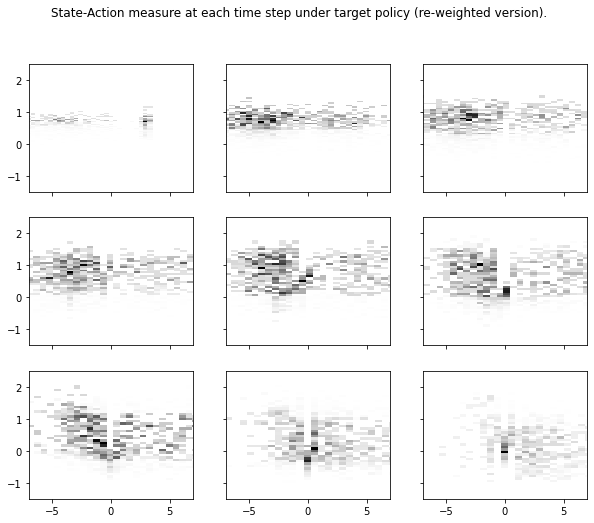

In [125]:
viz(w_all,bins =  40)

### Deep GIPWE

In [126]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim = 1, num_nodes = 16):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, num_nodes),
            nn.ReLU(),
            nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, num_nodes),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, num_nodes),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            #nn.Linear(num_nodes, num_nodes),
            #nn.ReLU(),
            # # #nn.Dropout(0.3),
            # # nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.flatten(x)
        target = self.linear_stack(x)
        return target

In [127]:
dev = "cuda:0"


learning_rate = 1e-2


Ind_out_n, Ind_in_n = get_split_ind(n,K)
Ind_out_m, Ind_in_m = get_split_ind(B*m,B)

w = np.ones(n)
w = torch.from_numpy(w)
w_ring = np.ones(m*B)
w_ring = torch.from_numpy(w_ring)
w_all = np.ones((T,n))


#model = RandomForestRegressor(n_estimators = 100, min_samples_split = 300)
for t in range(T):
    #print("T = {}:".format(t))
    for k in range(K):
        
        #print("Fold {}:".format(k+1))
        
        model = NeuralNetwork(input_dim = 2, num_nodes = 16).to(dev)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
        
        DGIPW = Deep_GIPW(X_natural[t,Ind_out_n[k],:], X_ring_natural[t], w_ring = w_ring, dev = dev)
        train_loss, test_loss = DGIPW.train(model, optimizer, epochs = 10)
        
        e = model(X_natural[t,Ind_in_n[k],:].to(dev))
        weights = e/(1.-e+DGIPW.epsilon) *DGIPW.n_/DGIPW.m_
        
        #weights = weights.to("cpu").detach().numpy()
        
        w_all[t,Ind_in_n[k]] = weights.to("cpu").detach().numpy().reshape((len(weights),))
        #print("train_loss:{}".format(train_loss[-1]))
        #print("test_loss:{}".format(test_loss[-1]))
        #print("\n")
    #w = w_all[t]
    w_ring = torch.from_numpy(w_all[t])
    for b in range(B-1):
        w_ring = torch.cat((w_ring,torch.from_numpy(w_all[t])))


In [128]:
get_reward(w_all)

645.9263954284337

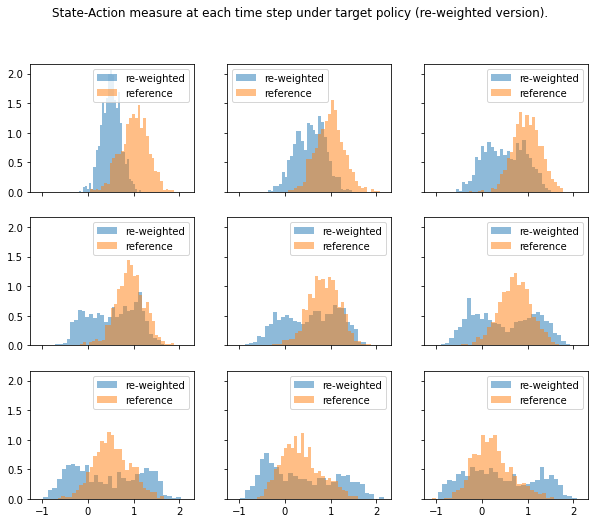

In [129]:
viz_marginal(w_all,1)

## Balancing

In [130]:
OTB = OptimalTransportBalancing()
#weights_OT = OTB.get_weights(xi,xi_ring,w,w_ring)
#weights = weights_OT.detach().numpy()

In [131]:
w = np.ones(n)
w_ring = np.ones(m*B)
w_all = np.ones((T,n))

#model = xgb.XGBRegressor(n_estimators = 10, gamma = 2)
for t in tqdm(range(T)):
    #print("T = {}:\n".format(t))
    w_all[t] = OTB.get_weights(source = X_natural[t],target = X_ring_natural[t],target_weights = w_ring).detach().numpy()
    
    w_ring = w_all[t]
    for b in range(B-1):
        w_ring = np.concatenate((w_ring,w_all[t]))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [13:28<00:00, 89.88s/it]


In [132]:
get_reward(w_all)

218.53245328683818

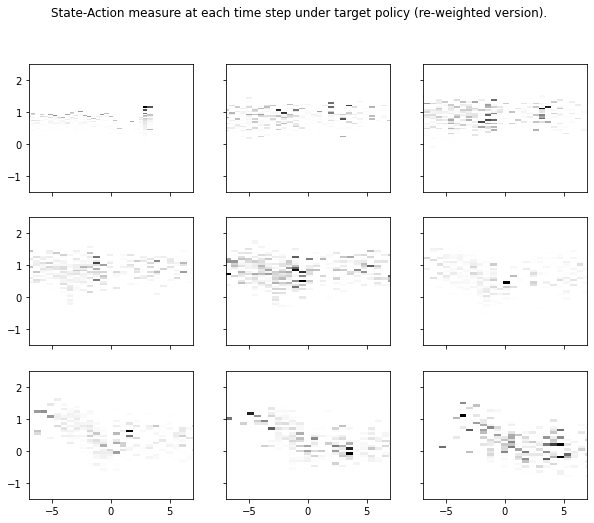

In [133]:

viz(w_all,bins =  40)

In [136]:
class MMDBalancing():
    def __init__(self,
                 xi, xi_ring,
                 w = None, w_ring = None,
                 sigma = 1, D = 500,
                 k = None, KXX = None, KXY = None, KYY = None,
                 dev = "cuda:0"):
        # init device
        self.dev = dev
        # init support of source and target measures
        self.xi = xi.to(self.dev) 
        self.xi_ring = xi_ring.to(self.dev)
        self.n,self.d = xi.shape
        self.m = xi_ring.shape[0]
        # init weights of source and target measures
        if w is not None:
            self.w = w.to(self.dev)
        else:
            self.w = torch.ones(n, device =self.dev)
        if w_ring is not None:
            self.w_ring = w_ring.to(self.dev)
        else:
            self.w_ring = torch.ones(m, device =self.dev)
        # init kernel matrices, when not provided, Gaussian kernel with random Fourier features is implemented
        if (KXX and KXY and KYY) is not None:
            self.KXX,self.KXY,self.KYY = KXX,KXY,KYY
        else:
            W = torch.normal(0,sigma,(D,self.d), device = self.dev)
            theta = torch.rand(D, device  = self.dev)*2*torch.pi
            Phi_X = torch.zeros((self.n,D), device = self.dev)
            Phi_Y = torch.zeros((self.m,D), device = self.dev)
            for j in range(D):
                Phi_X[:,j] = torch.cos(torch.matmul(W[j,:].T,self.xi.T) + theta[j])
                Phi_Y[:,j] = torch.cos(torch.matmul(W[j,:].T,self.xi_ring.T) + theta[j])
            
            self.KXX = torch.matmul(Phi_X,Phi_X.T)
            self.KYY = torch.matmul(Phi_Y,Phi_Y.T)
            self.KXY = torch.matmul(Phi_X,Phi_Y.T)
        
        self.alpha = torch.rand(self.n,device = self.dev,requires_grad=True)
            
        
        
        
        
    def get_weights(self, 
           lambda_l2 = 1e-1,
           lambda_RKHS = 1e2,
           ):
                
        #self.weights = torch.matmul(self.KXX,self.alpha)
        
        
      #direct solves
        y = self.w_ring.type(torch.cdouble)
        lambda_RKHS = 1e2
        lambda_l2 = 1e-1
    
        KXX = self.KXX.type(torch.cdouble)
        KXX_2 = torch.matmul(KXX.T,KXX)
        KXY = self.KXY.type(torch.cdouble)
        self.alpha = torch.matmul(torch.matmul(torch.linalg.inv(torch.matmul(KXX.T, KXX)+lambda_RKHS*KXX + lambda_l2*KXX_2),KXY),y)
        self.weights = torch.real(torch.matmul(KXX,self.alpha))
        return self.weights



In [23]:
def iter_t(t,xi,xi_ring, w,w_ring,
           sigma = 1e2, max_iter = 10, lambda_RKHS = 1e2, lambda_l2 = 1e-1, threshold = 0.1, ref_mean = 1, auto_tuning = True):
    
    sig_now = sigma
    if auto_tuning:
        
        sig_smallest = 0
        for i in range(max_iter):
            MMDB = MMDBalancing(xi,xi_ring,w,w_ring,sigma =sig_now,D = 2000)
            weights = MMDB.get_weights(lambda_RKHS = lambda_RKHS, lambda_l2 = lambda_l2)
            
            # keep positive weights
            weights = weights*(weights>0)
            
            
            if torch.abs(torch.mean(weights) - ref_mean).item() < threshold:
                break
            if torch.mean(weights) > ref_mean:
                _sig = sig_now
                try:
                    sig_now = (sig_now+sig_largest)/2
                except:
                    sig_now = 2*sig_now
                sig_smallest = _sig
            elif torch.mean(weights) < ref_mean:
                sig_largest = sig_now
                sig_now = (sig_smallest+sig_now)/2
    else:
        MMDB = MMDBalancing(xi,xi_ring,w,w_ring,sigma =sig_now,D = 2000)
        weights = MMDB.get_weights(lambda_RKHS = lambda_RKHS, lambda_l2 = lambda_l2)
        # keep positive weights
        weights = weights*(weights>0)
        
    print(torch.mean(weights))
    return weights
            
            
    

In [108]:
n = 200
m = 200
B = 3
T = 9
K = 2
h =0 


X,A,X_natural,X_ring_oracle,A_ring_oracle,X_ring_natural_oracle = get_data(n = n,m = m,  h = h)
X_ring_natural,X_ring,A_ring = get_X_natural(X = X, X_ring_0 = X_ring_oracle[0], B=B)
print(get_ref(h = h))




dev = "cuda:0"
w = torch.ones(n, device = dev)
w_ring = torch.ones(m*B, device = dev)
w_all = torch.ones((T,n), device = dev)


for t in tqdm(range(T)):
    
    lambda_RKHS = 1e2
    lambda_l2 = 1e2
    w_all[t] = iter_t(t = t,
                      xi = X_natural[t],
                      xi_ring= X_ring_natural[t], w_ring = w_ring,
                      w = None,
                      sigma = 1e2,threshold = 0.2, max_iter = 80,lambda_RKHS = lambda_RKHS, lambda_l2 = lambda_l2, auto_tuning = True )
    

    
    #w_all[t] = w_all[t]/w_all[t].mean()
    w_ring = w_all[t]
    for b in range(B-1):
        w_ring = torch.cat((w_ring,w_all[t]))

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

tensor(291.8108)


 11%|█████████▎                                                                          | 1/9 [00:01<00:15,  1.89s/it]

tensor(0.9783, device='cuda:0', dtype=torch.float64)


 22%|██████████████████▋                                                                 | 2/9 [00:03<00:13,  1.88s/it]

tensor(1.1027, device='cuda:0', dtype=torch.float64)


 33%|████████████████████████████                                                        | 3/9 [00:05<00:10,  1.67s/it]

tensor(0.8002, device='cuda:0', dtype=torch.float64)


 44%|█████████████████████████████████████▎                                              | 4/9 [00:07<00:08,  1.77s/it]

tensor(0.9996, device='cuda:0', dtype=torch.float64)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:10<00:09,  2.34s/it]

tensor(0.9913, device='cuda:0', dtype=torch.float64)


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:12<00:07,  2.37s/it]

tensor(0.8963, device='cuda:0', dtype=torch.float64)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:14<00:04,  2.22s/it]

tensor(0.9331, device='cuda:0', dtype=torch.float64)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:16<00:02,  2.13s/it]

tensor(0.9349, device='cuda:0', dtype=torch.float64)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.08s/it]

tensor(0.9385, device='cuda:0', dtype=torch.float64)


In [109]:
w_all = w_all.to("cpu").detach().numpy()
#w_all = w_all*(w_all>0)

In [110]:
get_reward(w_all, X = X)

219.8933563232422

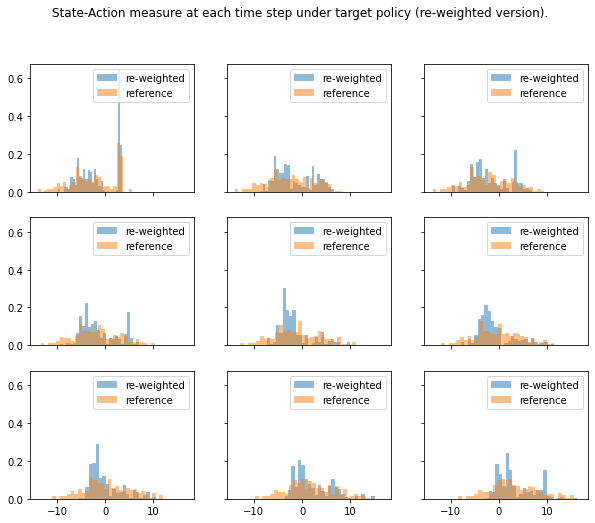

In [111]:
viz_marginal(w_all,0)

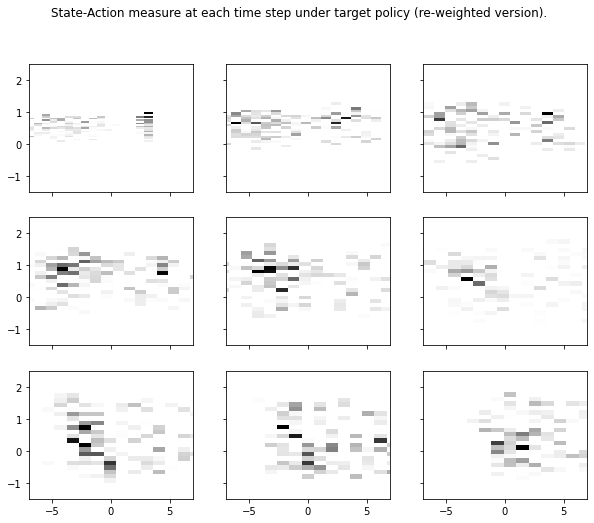

In [112]:
viz(w_all,bins = 20)